In [4]:
import pandas as pd
import quandl
import matplotlib.pyplot as plt
import math

### Bolinger Band 그리기 위한 sigma 계산 helper function

In [5]:
def variance_calculator(series,series_average,win_len):
	sma = win_len
	temp = series.subtract(series_average)          # a-b
	temp2 = temp.apply(lambda x: x**2)              #(a-b)^2
	temp3 = temp2.rolling(sma-1).mean()             # summation[(a-b)^2 ]/ (sma - 1)
	sigma = temp3.apply(lambda x : math.sqrt(x))    #sigma is the standard deviation
	return sigma

def fetch_data(string1,string2,string3,filename):
	w = quandl.get(string1,authtoken = string2, start_date = string3)
	w.to_csv(filename)
	w = pd.read_csv(filename)
	return w

In [6]:
# S&P500 future data fetch from "CHRIS/CME_SP1" database
Data1 = fetch_data("CHRIS/CME_SP1", "U_Gp39gZutpHmaFgC65Y","2014-12-12", "local_future.csv")
Data = fetch_data("CBOE/SPX_PC", "U_Gp39gZutpHmaFgC65Y", "2014-12-12", "local_data.csv")

In [7]:
Data['future'] = Data1['Last']
Data['PCR'] = Data['S&P PUT-CALL RATIO'] # PCR IS Put Call Ratio


In [8]:
Data.head(2)            

,Date,S&P PUT-CALL RATIO,S&P PUT VOLUME,S&P CALL VOLUME,PREV. DAY OPEN INTEREST,future,PCR
0,2014-12-12,2.49,1072264.0,430079.0,1502343.0,1997.5,2.49
1,2014-12-15,2.46,913199.0,371125.0,1284324.0,1991.0,2.46


### Initialize variables which will be used later

In [9]:
sma = 20 #............................the moving average window length
k = 1 # ..............................constant representing 'k' times sigma away from moving average(for Bollinger Bands)
l = 1 #...............................constant representing 'l' times sigma away from Bollinger bands( for stoploss band)
flag = 1 #............................flag is there to begin first transaction--- transaction should start with LBB/UBB crossing only
pro = 0 #.............................profit variable
transaction_start_price = 0
buy_flag = False 
sell_flag = False
abs_SL = 5
mtm = list()
order = list()#...........................order is  a list which contains the orders:- BUY/SELL/DO_Nothing
profit = list()
buy_sell = list()
stoploss = list()
trade_cause = list()
order_details = list()


In [10]:

Data['mAvg'] = Data['PCR'].rolling(sma).mean()   #calculating the moving average of the PCR
Data['PCR_prev'] = Data['PCR'].shift(1)          #moving average shifted ahead to check for crossover


sigma = variance_calculator(Data['PCR'],Data['mAvg'],sma)#calculating the standard deviation
k_sigma = k*sigma
l_sigma = l*sigma

Data['UBB'] = Data['mAvg'].add(k_sigma) #.........upper bollinger band
Data['USL'] = Data['UBB'].add(l_sigma)#...........upper stoploss band
Data['LBB'] = Data['mAvg'].subtract(k_sigma)#.....lower bollinger band
Data['LSL'] = Data['LBB'].subtract(l_sigma)#......lower stoploss band
Data['order'] = pd.Series() #.....................order is  a list which contains the orders:- BUY/SELL/DO_Nothing

s = Data['PCR'].size#.................size of the PCR series

In [16]:
for i in range(s):
	pro = 0 # profit at each trade
	#variables to be used for comarison
	future_cost = Data['future'][i]#...........cost of big S&P 500 futures bought
	PCR      =   Data['PCR'][i]#...............current putcall ratio value
	PCR_prev  =   Data['PCR_prev'][i]#.........previous day's put call ratio (for crossover check)
	LBB      =   Data['LBB'][i] #..............lower bollinger band
	UBB      =   Data['UBB'][i]#...............upper bollinger band
	mAvg     =   Data['mAvg'][i]#..............moving average
	USL      =   Data['USL'][i]#...............upper stoploss band
	LSL      =   Data['LSL'][i] #..............lower stoploss band
    
    #comparisons stored as boolean variables to place order accordingly
	UBB_cross        =   (PCR > UBB) and (PCR_prev < UBB)# .......Check if PCR crosses upper bollinger band
	LBB_cross        =   (PCR < LBB) and (PCR_prev > LBB)# .......Check if PCR crosses lower bollinger band
	mAvg_cross_up    =   (PCR > mAvg) and (PCR_prev < mAvg)#......Check if PCR crosses moving average low to high
	mAvg_cross_down  =   (PCR < mAvg) and (PCR_prev > mAvg)#......Check if PCR crosses moving average high to low
	USL_cross        =   (PCR > USL)  and  (PCR_prev < USL)#......Check if PCR crosses upper stoploss band
	LSL_cross        =   (PCR < LSL)  and  (PCR_prev > LSL)#......Check if PCR crosses lower stoploss band
    
	if(UBB_cross and (not buy_flag) and flag ==1): #...........places "BUY" order if PCR crosses upper bollinger band to open a trade
		flag = 0
		buy_flag = True      
		sell_flag = False
		transaction_start_price = future_cost #............price at which S&P 500 future bought when order is placed
		order_details = [1,"Buy" , "UBB crossed" , "0" , "position taken"]
	
	elif (LBB_cross and (not sell_flag) and flag ==1): #.......places "SELL" order if PCR crosses lower bollinger band to open a trade
		flag = 0
		sell_flag = True  
		buy_flag = False
		transaction_start_price = future_cost
		order_details = [-1,"Sell" , "LBB crossed" , "0" , "position taken"]
	
	elif (mAvg_cross_up and flag==0 and (not buy_flag)) : #........places "BUY" order if PCR crosses mAvg from low to high to close a trade  
		flag = 1
		buy_flag = False 
		sell_flag = False
		pro = future_cost -transaction_start_price
		order_details = [1,"Buy" , "mAvg crossed" , "0" , "position closed"]
	elif( LSL_cross and flag == 0 and (not buy_flag)):#......places "BUY" order if PCR crosses lower stoploss band to close a trade
		flag = 1
		buy_flag = False
		sell_flag = False
		pro = future_cost - transaction_start_price
		order_details = [1,"Buy" , "LSB crossed" , "stoploss executed" , "position closed"]
	elif( (future_cost - transaction_start_price) > abs_SL and flag == 0 and (not buy_flag)):#......places "BUY " order if PCR crosses lower stoploss absolute value
		flag = 1
		buy_flag = False
		sell_flag = False
		pro = future_cost - transaction_start_price
		order_details = [1,"Buy" , "LSB crossed" , "stoploss executed abs" , "position closed"]		
				
	elif (mAvg_cross_down and flag==0 and (not sell_flag)):#.....places "SELL" order if PCR crosses mAvg from high to low to close a trade
		flag = 1
		sell_flag = False
		buy_flag = False
		pro = -(Data['future'][i] - transaction_start_price)
		order_details = [-1,"Sell" , "mAvg crossed (h to l)" , "0" , "position closed"]
	elif(USL_cross and flag==0 and (not sell_flag)):# ..places "SELL" order if PCR crosses upper stoploss band to close a trade
		flag = 1
		sell_flag = False
		buy_flag = False
		pro = -(Data['future'][i] - transaction_start_price)
		order_details = [-1,"Sell" , "USB crossed" , "stoploss executed" , "position closed"]
	
	elif((-future_cost + transaction_start_price) > abs_SL and flag==0 and (not sell_flag)):# ..places "SELL" order if PCR crosses upper stoploss absolute value
		flag = 1
		sell_flag = False
		buy_flag = False
		pro = -(Data['future'][i] - transaction_start_price)
		order_details = [-1,"Sell" , "USB crossed" , "stoploss executed_abs" , "position closed"]
	else:
		if(buy_flag==0 and sell_flag==0): tempo = "0"
		else:
			if(buy_flag==1 and sell_flag==0): tempo = (Data['future'][i] -transaction_start_price) * 500
			if(buy_flag==0 and sell_flag==1): tempo= (-Data['future'][i] +transaction_start_price) * 500
		order_details = [0,"No trade" , "no trade" , "0" , tempo]
	profit.append(pro)
	order.append(order_details[0])
	buy_sell.append(order_details[1])
	trade_cause.append(order_details[2])
	stoploss.append(order_details[3])
	mtm.append(order_details[4])


In [18]:
Data['placed_order'] = pd.Series(order) #...............................converting list to pandas series
Data['cost'] = -(Data['placed_order'].multiply(Data['future'])) *500# ..cost at each transaction
Data['out'] = Data['cost'].cumsum()# ...................................out is the cumulative cost profit/loss after transactions till now
Data['buy_sell'] = pd.Series(buy_sell)
Data['profit'] = -pd.Series(profit) * 500
Data['stoploss'] = pd.Series(stoploss)
Data['trade_cause']  = pd.Series(trade_cause)
Data['mtm'] = pd.Series(mtm)
print(Data['out'])


0           -0.0
1           -0.0
2           -0.0
3           -0.0
4           -0.0
5           -0.0
6           -0.0
7           -0.0
8           -0.0
9           -0.0
10          -0.0
11          -0.0
12          -0.0
13          -0.0
14          -0.0
15          -0.0
16          -0.0
17          -0.0
18          -0.0
19          -0.0
20          -0.0
21          -0.0
22          -0.0
23          -0.0
24          -0.0
25          -0.0
26          -0.0
27          -0.0
28          -0.0
29          -0.0
         ...    
892    3727650.0
893    5091150.0
894    5091150.0
895    5091150.0
896    5091150.0
897    5091150.0
898    5091150.0
899    5091150.0
900    6490550.0
901    6490550.0
902    5092050.0
903    6497550.0
904    6497550.0
905    6497550.0
906    5097300.0
907    5097300.0
908    5097300.0
909    6518050.0
910    5096800.0
911    5096800.0
912    5096800.0
913    5096800.0
914    3691550.0
915    3691550.0
916    3691550.0
917    5116600.0
918    5116600.0
919    5116600

In [19]:

output = pd.DataFrame() #....final output to be stored in excel file
output['date'] = Data1['Date']
output['Close'] = Data['future']
output['PCR'] = Data['PCR']
output['placed_order'] = Data['placed_order']
output['buy_sell'] = Data['buy_sell']
output['trade_cause'] =  Data['trade_cause']
output['PnL'] = Data['profit']
output['mtm'] = Data['mtm']
output['stoploss'] = Data['stoploss']
output['Cash Account'] = Data['out']
output.to_excel('PCR_SL_output.xlsx', sheet_name='Sheet1')


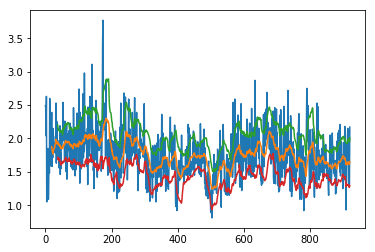

In [20]:

#plt.plot(order)
plt.plot(Data['PCR'])
plt.plot(Data['mAvg'])
plt.plot(Data['UBB'])
plt.plot(Data['LBB'])
#plt.plot(Data['out'])
plt.show()